# Joint flight data — Overview

In [1]:
from netCDF4 import Dataset
import glob
from joint_flight.data import hamp, rasta, ismar, dem
from joint_flight.notebook import *
import joint_flight.data.in_situ.faam as data

No environment variable JOINT_FLIGHT_PATH found. Will look in /home/simonpf/src/joint_flight/joint_flight/..  for the joint flight data.


## Flight path

### Modis image

In [2]:
import os
from joint_flight import path
from pyhdf.SD import SD
from scipy.interpolate import RegularGridInterpolator
import numpy as np
modis = SD(os.path.join(path, "data", "modis_l1b_250.hdf"))

# Interpolate lat and lon grids
modis_lat = modis.select("Latitude")[:]
modis_lon = modis.select("Longitude")[:]

ref_sb = modis.select("EV_250_RefSB")
attrs = ref_sb.attributes()
modis_r = attrs["reflectance_scales"][0] * (ref_sb[0, :, :] - attrs["reflectance_offsets"][0])

lat_min, lat_max = [55.5, 60.5]
lon_min, lon_max = [-9, 4]


inds = np.logical_and(np.logical_and(modis_lat > lat_min, modis_lat < lat_max),
                      np.logical_and(modis_lon > lon_min, modis_lon < lon_max))
inds_i, inds_j = np.where(inds)
i_start, i_end = inds_i.min(), inds_i.max()
j_start, j_end = inds_j.min(), inds_j.max()

modis_lat = modis_lat[i_start : i_end, j_start : j_end]
modis_lon = modis_lon[i_start : i_end, j_start : j_end]
modis_r = modis_r[i_start * 4 : i_end * 4, j_start * 4: j_end * 4]

In [3]:
x = np.arange(modis_lat.shape[0])
y = np.arange(modis_lat.shape[1])
f_lat = RegularGridInterpolator([x, y] , modis_lat)
xf = np.linspace(0, modis_lat.shape[0] -1, modis_r.shape[0])
yf = np.linspace(0, modis_lat.shape[1] -1, modis_r.shape[1])
xf, yf = np.meshgrid(xf, yf)
modis_lat_f = f_lat(np.hstack([xf.reshape(-1, 1), yf.reshape(-1, 1)]))
modis_lat_f = modis_lat_f.reshape(modis_r.shape, order = "F")

x = np.arange(modis_lon.shape[0])
y = np.arange(modis_lon.shape[1])
f_lon = RegularGridInterpolator([x, y] , modis_lon)
xf = np.linspace(0, modis_lon.shape[0] -1, modis_r.shape[0])
yf = np.linspace(0, modis_lon.shape[1] -1, modis_r.shape[1])
xf, yf = np.meshgrid(xf, yf)
modis_lon_f = f_lon(np.hstack([xf.reshape(-1, 1), yf.reshape(-1, 1)]))
modis_lon_f = modis_lon_f.reshape(modis_r.shape, order = "F")

In [4]:
ref_sb.attributes()

{'long_name': 'Earth View 250M Reflective Solar Bands Scaled Integers',
 'units': 'none',
 'valid_range': [0, 32767],
 '_FillValue': 65535,
 'band_names': '1,2',
 'radiance_scales': [0.028396980836987495, 0.010617767460644245],
 'radiance_offsets': [-0.0, -0.0],
 'radiance_units': 'Watts/m^2/micrometer/steradian',
 'reflectance_scales': [5.524477455765009e-05, 3.3438176615163684e-05],
 'reflectance_offsets': [-0.0, -0.0],
 'reflectance_units': 'none',
 'corrected_counts_scales': [0.12497329711914062, 0.12497329711914062],
 'corrected_counts_offsets': [-0.0, -0.0],
 'corrected_counts_units': 'counts'}

Text(0, 0.5, '$\\unit{m}$')

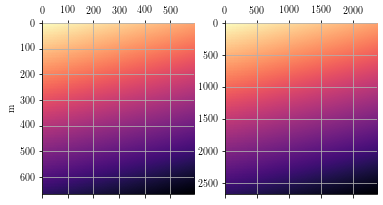

In [6]:
f, axs = plt.subplots(1, 2)
axs[0].matshow(modis_lat)
axs[1].matshow(modis_lat_f)
axs[0].set_ylabel(r"$\unit{m}$")

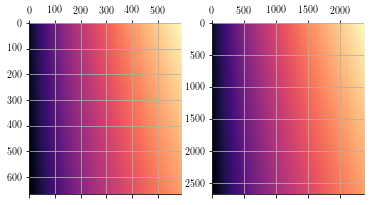

In [6]:
f, axs = plt.subplots(1, 2)
axs[0].matshow(modis_lon)
axs[1].matshow(modis_lon_f)

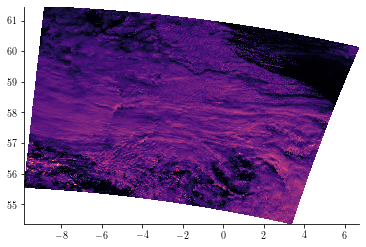

In [7]:
plt.pcolormesh(modis_lon_f, modis_lat_f, modis_r)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


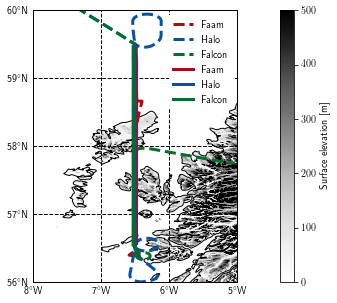

In [9]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors     import Normalize
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 2, width_ratios = [1.0, 0.06], hspace = 0.25)
fig = plt.figure(figsize = (5, 5))
ax  = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())

c1 = "C0"
c2 = "C1"
c3 = "C2"

ax._hold = True
ax.plot(ismar.lon_e, ismar.lat_e, lw = 3, label = "Faam", c = c1, ls = "--")
ax.plot(hamp.lon_e, hamp.lat_e, label = "Halo", lw = 3, c = c2, ls = "--")
ax.plot(rasta.lon_e, rasta.lat_e, label = "Falcon", lw = 3, c = c3, ls = "--")
ax.plot(ismar.lon + 0.025, ismar.lat, lw = 3, label = "Faam", c = c1)
ax.plot(hamp.lon, hamp.lat, label = "Halo", lw = 3, c = c2)
ax.plot(rasta.lon - 0.025, rasta.lat, label = "Falcon", lw = 3, c = c3)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlocator   = mticker.FixedLocator(np.linspace(-8, -5, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.ylocator   = mticker.FixedLocator(np.linspace(56, 60, 5))
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top   = False

ax.coastlines(resolution = "10m", linewidth = 1)

norm = Normalize(vmin = 0, vmax = 500)
img = ax.pcolormesh(dem.lon[::2], dem.lat[::2], dem.z[::2, ::2],
              norm = norm,
              cmap = "Greys")

ax.set_xlim([-8.0001, -4.9999])
ax.set_ylim([55.9999, 60.0001])
ax.legend()

for s in ax.spines:
    ax.spines[s].set_visible(True)

fig.colorbar(img, label = "Surface elevation [m]", cax = plt.subplot(gs[1]))

plt.tight_layout()
fig.savefig("../plots/flight_path.png")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


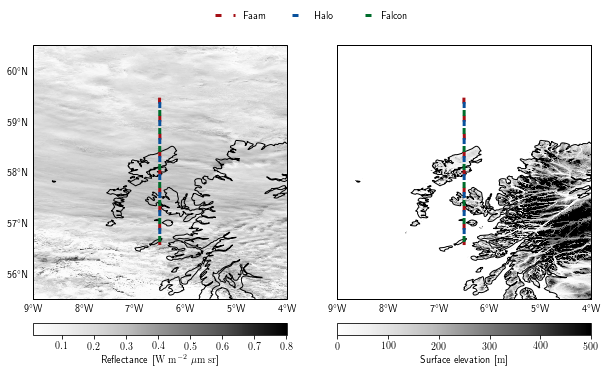

In [28]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors     import Normalize
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.gridspec import GridSpec

gs = GridSpec(3, 2, width_ratios = [1.0, 1.0], height_ratios = [0.05, 1.0, 0.05], hspace = 0.25)
fig = plt.figure(figsize = (10, 6))

#
# MODIS image
#

ax  = fig.add_subplot(gs[1, 0], projection = ccrs.PlateCarree())

handles = []
handles += ax.plot(ismar.lon, ismar.lat, lw = 3, label = "Faam", c = c1, ls = (0, (2, 4)))
handles += ax.plot(hamp.lon, hamp.lat, label = "Halo", lw = 3, c = c2, ls = (0, (0, 2, 2, 2)))
handles += ax.plot(rasta.lon, rasta.lat, label = "Falcon", lw = 3, c = c3, ls = (0, (0, 4, 2, 0)))

ls = ax.coastlines(resolution = "10m", lw = 1)
img = ax.pcolormesh(modis_lon_f, modis_lat_f, modis_r, cmap = "Greys")

ax.set_xlim([-9.0001, -3.9999])
ax.set_ylim([55.4999, 60.5001])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='black', linestyle='--')
gl.xlocator   = mticker.FixedLocator(np.linspace(-9, -4, 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.ylocator   = mticker.FixedLocator(np.linspace(55, 61, 7))
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top   = False

# Colorbar
ax = plt.subplot(gs[2, 0])
plt.colorbar(img, cax = ax, orientation = "horizontal",
             label = r"Reflectance [$\unit{W\ m^{-2}\ \mu m\ sr}$]")


#
# Topography
#

c1 = "C0"
c2 = "C1"
c3 = "C2"

ax  = fig.add_subplot(gs[1, 1], projection = ccrs.PlateCarree())
ax._hold = True
handles = []
handles += ax.plot(ismar.lon, ismar.lat, lw = 3, label = "Faam", c = c1,   ls = (0, (2, 4))      )
handles += ax.plot(hamp.lon, hamp.lat, label = "Halo", lw = 3, c = c2,     ls = (0, (0, 2, 2, 2)))
handles += ax.plot(rasta.lon, rasta.lat, label = "Falcon", lw = 3, c = c3, ls = (0, (0, 4, 2, 0)))


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='black', linestyle='--')
gl.xlocator   = mticker.FixedLocator(np.linspace(-9, -4, 6))
gl.xformatter = LONGITUDE_FORMATTER
gl.ylocator   = mticker.FixedLocator(np.linspace(55, 61, 7))
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlabels_top   = False

ax.coastlines(resolution = "10m", linewidth = 1)

norm = Normalize(vmin = 0, vmax = 500)
img = ax.pcolormesh(dem.lon[::2], dem.lat[::2], dem.z[::2, ::2],
              norm = norm,
              cmap = "Greys")

ax.set_xlim([-9.0001, -3.9999])
ax.set_ylim([55.4999, 60.5001])

for s in ax.spines:
    ax.spines[s].set_visible(True)

ax = plt.subplot(gs[0, :])
ax.set_axis_off()
labels = ["Faam", "Halo", "Falcon"]
ax.legend(handles = handles, labels = labels, loc = "center", ncol = 3)


# Colorbar    
fig.colorbar(img, label = r"Surface elevation [$\unit{m}$]", orientation = "horizontal",
             cax = plt.subplot(gs[2, 1]))

plt.tight_layout()
fig.savefig("../plots/flight_paths.png", dpi = 300)

## Radar reflectivities

In [3]:
palette = ["#34495e", "#9b59b6", "#3498db", "#95a5a6", "#2ecc71", "#e74c3c"]

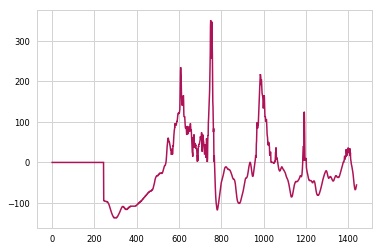

In [4]:
plt.plot(hamp.zs)

In [5]:
from netCDF4 import Dataset
input_data = Dataset("../data/input.nc")
y_hamp_radar   = input_data["y_hamp_radar"][:]
y_hamp_passive = input_data["y_hamp_passive"][:]
y_ismar        = input_data["y_ismar"][:]
y_rasta        = input_data["y_rasta"][:]
input_data.close()

In [6]:
def make_surface_plot(ax1, ax2):
    zs = np.copy(hamp.zs)
    zs[zs <= 0.0] = -1e3
    handles = []
    handles += [ax1.fill_between(hamp.d, 0.0, -1e3, color = palette[0])]
    handles += [ax1.fill_between(hamp.d, zs, -1e3, color = palette[3])]
    ax1.set_ylabel("Elev. [m]")
    ax1.set_xlabel("Along track distance [km]")
    ax1.set_ylim([-100, 400])
    ax1.set_xlim([hamp.d[0], hamp.d[-1]])
    ax1.grid(False)
    
    
    labels = ["Ocean", "Land"]
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.legend(handles = handles, labels = labels, loc = "center left")
    for s in ax2.spines:
        ax2.spines[s].set_visible(False)

No handles with labels found to put in legend.


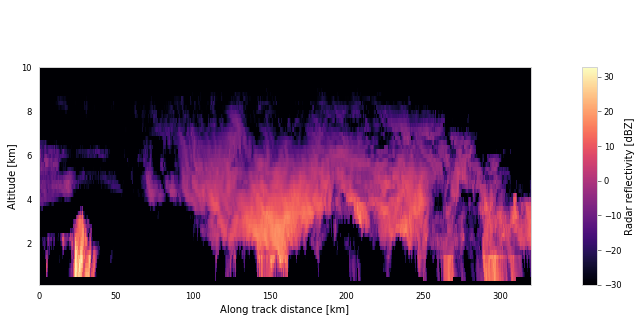

In [7]:
from joint_flight.plots  import grid_to_edges
from joint_flight.data   import hamp, ismar, dem
from joint_flight.plots  import grid_to_edges
from matplotlib.gridspec import GridSpec

fig  = plt.figure(figsize = (10, 4))
gs = GridSpec(1, 2, width_ratios = [1, 0.03])

x = hamp.d
y = np.linspace(0.2, 10, 50)
xx, yy = np.meshgrid(x, y)
xx = grid_to_edges(xx)
yy = grid_to_edges(yy)

#
# HAMP RADAR
#

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(xx, yy, y_hamp_radar.T, cmap = "magma")
fig.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")

ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Along track distance [km]")
ax.set_ylim([0.1, 10])
ax.set_xlim([0, 320])
ax.legend(loc = "upper center", bbox_to_anchor = [0.5, 1.3])

fig.savefig("/home/simon//presentations/miscellaneous/rcg/radar_reflectivities.png")

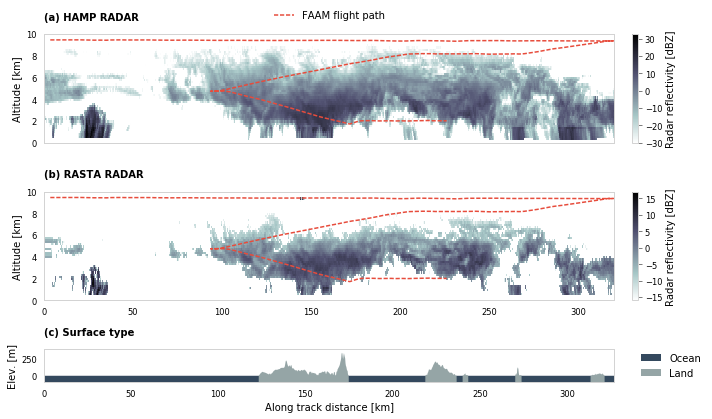

In [8]:
from joint_flight.plots  import grid_to_edges
from joint_flight.data   import hamp, ismar, dem
from joint_flight.plots  import grid_to_edges
from matplotlib.gridspec import GridSpec

fig  = plt.figure(figsize = (10, 6))
gs = GridSpec(3, 2, width_ratios = [1, 0.01], height_ratios = [1.0, 1.0, 0.3])

x = hamp.d
y = np.linspace(0.2, 10, 50)
xx, yy = np.meshgrid(x, y)
xx = grid_to_edges(xx)
yy = grid_to_edges(yy)

#
# HAMP RADAR
#

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(xx, yy, y_hamp_radar.T, cmap = "bone_r")
fig.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")

ax.set_title("(a) HAMP RADAR", loc = "left", fontweight = "bold")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.xaxis.set_ticks([])
ax.plot(ismar.d_e.ravel(), ismar.zsl_e / 1e3, c = palette[-1], ls = "--", label = "FAAM flight path")
ax.legend(loc = "upper center", bbox_to_anchor = [0.5, 1.3])

#
# RASTA RADAR
#

ax = plt.subplot(gs[1, 0])
img = ax.pcolormesh(xx, yy, y_rasta.T, cmap = "bone_r")
fig.colorbar(img, cax = plt.subplot(gs[1, 1]), label = "Radar reflectivity [dBZ]")

ax.set_title("(b) RASTA RADAR", loc = "left", fontweight = "bold")
#ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.plot(ismar.d_e.ravel(), ismar.zsl_e / 1e3, c = palette[-1], ls = "--", label = "FAAM flight path")

#
# Surface
#

ax1 = plt.subplot(gs[2, 0])
ax2 = plt.subplot(gs[2, 1])
ax1.set_title("(c) Surface type", loc = "left", fontweight = "bold")
make_surface_plot(ax1, ax2)

plt.tight_layout()
fig.savefig("../plots/radar_reflectivities.png")

## HAMP brighness temperatures

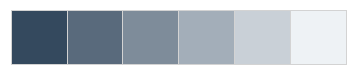

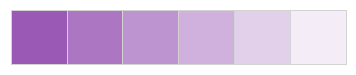

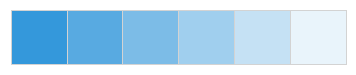

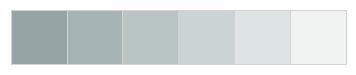

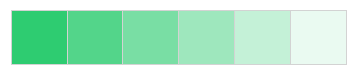

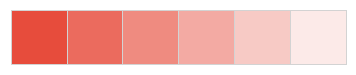

In [9]:
import seaborn as sns
sns.reset_orig()

cs = ["navy", "firebrick", ]
cs = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
cs = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "firebrick"]
cs = palette
sns.light_palette("navy", reverse=True)
for c in cs:
    sns.palplot(sns.light_palette(c, reverse=True))

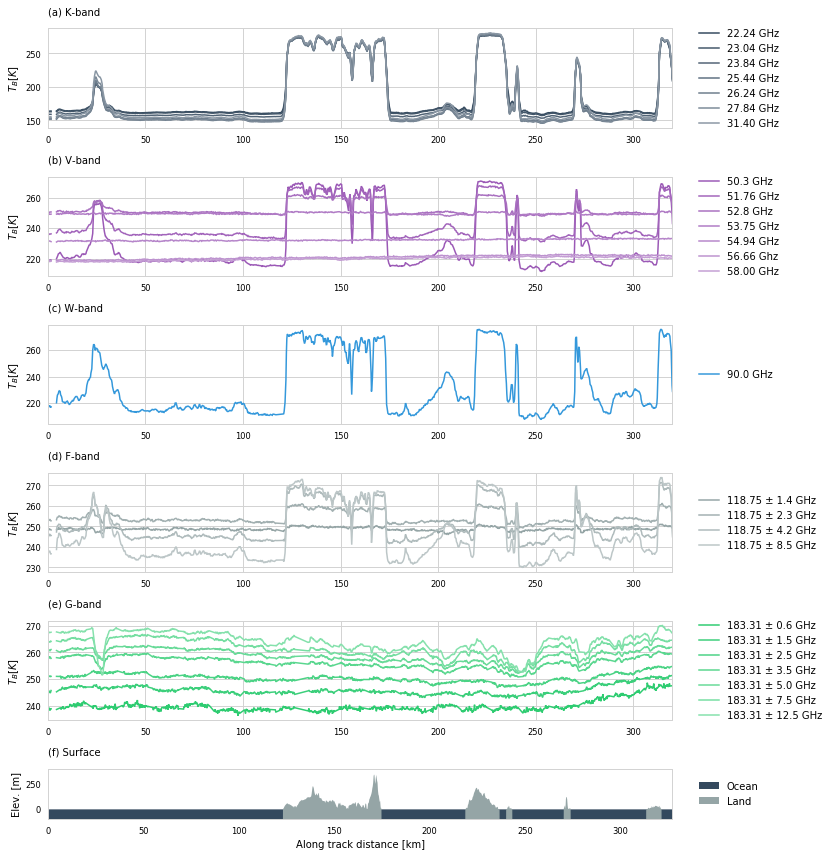

In [10]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 12))
gs = GridSpec(6, 2, width_ratios = [1, 0.2], height_ratios = [1] * 5 + [0.5])

channel_names_hamp = [["22.24 GHz", "23.04 GHz", "23.84 GHz", "25.44 GHz",   \
                   "26.24 GHz", "27.84 GHz", "31.40 GHz"],               \
                      ["50.3 GHz", "51.76 GHz", "52.8 GHz", "53.75 GHz", "54.94 GHz", \
                       "56.66 Ghz", "58.00 GHz"],
                      ["90.0 GHz"],
                      ["118.75 ± 8.5 GHz", "118.75 ± 4.2 GHz", "118.75 ± 2.3 GHz", \
                       "118.75 ± 1.4 GHz"][::-1], 
                      ["183.31 ± 12.5 GHz", "183.31 ± 7.5 GHz", "183.31 ± 5.0 GHz", \
                       "183.31 ± 3.5 GHz", "183.31 ± 2.5 GHz", "183.31 ± 1.5 GHz",  \
                       "183.31 ± 0.6 GHz"][::-1]]

band_names = ["(a) K-band", "(b) V-band", "(c) W-band", "(d) F-band", "(e) G-band"]
for i in range(5):
    
    ncs = len([c for c in hamp.channels if c == i + 1]) * 2
    cp = sns.light_palette(cs[i], ncs, reverse = True)
    
    ax = plt.subplot(gs[i, 0])
    ax.set_title(band_names[i], loc = "left")
    
    ci = 0
    handles = []
    labels  = []
    for j, c in enumerate(hamp.channels):
        if i + 1 == c:
            handles += ax.plot(hamp.d, hamp.bt[:, j], c = cp[ci], label = channel_names_hamp[i][ci])
            labels += [channel_names_hamp[i][ci]]
            ci += 1
            
    ax.set_xlim([0, 320])
    ax.set_ylabel("$T_B [K]$")
    
    ax = plt.subplot(gs[i, 1])
    ax.legend(handles = handles, labels = labels, loc = "center left", ncol = 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for s in ax2.spines:
        ax.spines[s].set_visible(False)
            

ax1 = plt.subplot(gs[5, 0])
ax2 = plt.subplot(gs[5, 1])
make_surface_plot(ax1, ax2)
ax1.set_title("(f) Surface", loc = "left")

plt.tight_layout()

f.savefig("../plots/hamp_passive.pdf", bbox_inches = "tight")

## ISMAR brightness temperatures

In [11]:
channel_names_ismar = [["118 ± 1.1 GHz", "118 ± 1.5 GHz", "118 ± 2.1 GHz", "118 ± 3.0 GHz", "118 ± 5.0 GHz"],
                       ["243 GHz"],
                       ["325 ± 1.5 GHz", "325 ± 3.5 GHz", "325 ± 9.5 GHz"],
                       ["664 GHz, H"]]
channel_indices = [list(range(5)), [5], [6, 7, 8], [9]]

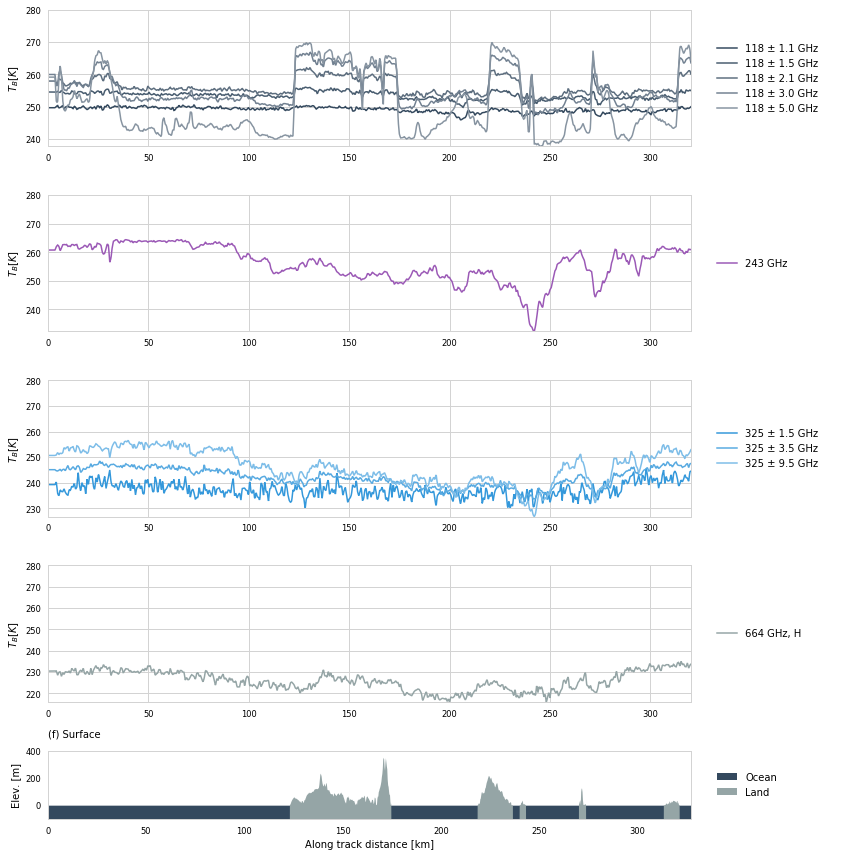

In [12]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 12))
ncs = len(channel_names_ismar)
gs = GridSpec(ncs + 1, 2, width_ratios = [1, 0.2], height_ratios = [1] * ncs  + [0.5])

for i, (names, indices) in enumerate(zip(channel_names_ismar, channel_indices)):
    
    ncs = len(channel_names_ismar[i]) * 2
    cp = sns.light_palette(cs[i], ncs, reverse = True)
    
    ax = plt.subplot(gs[i, 0])
    
    ci = 0
    handles = []
    labels  = []
    y_min = 300.0
    y_max = 280.0
    for n, j in zip(names, indices):
        handles += ax.plot(hamp.d, y_ismar[:, j], c = cp[ci])
        labels += [n]
        y_min = np.minimum(y_min, y_ismar[:, j].min())
        y_max = np.maximum(y_max, y_ismar[:, j].max())
        ci += 1
        
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([0, 320])
    ax.set_ylabel("$T_B [K]$")
    
    ax = plt.subplot(gs[i, 1])
    ax.legend(handles = handles, labels = labels, loc = "center left", ncol = 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for s in ax2.spines:
        ax.spines[s].set_visible(False)
            

ax1 = plt.subplot(gs[-1, 0])
ax2 = plt.subplot(gs[-1, 1])
make_surface_plot(ax1, ax2)
ax1.set_title("(f) Surface", loc = "left")

plt.tight_layout()

f.savefig("../plots/ismar_passive.pdf", bbox_inches = "tight")

## Combined observations

In [17]:
lower_names = ["HAMP, 52.8 GHz", "HAMP, 90 GHz", "ISMAR, 118 ± 2.1 GHz"]
lower_tbs    = [y_hamp_passive[:, 9], y_hamp_passive[:, 14], y_ismar[:, 2]]
lower_cs = ["C0", "C1", "C2", "C3"] #palette #["navy", "purple", "mediumseagreen"]
upper_names = ["HAMP, 183 ± 3.5 GHz", "ISMAR, 243 GHZ", "ISMAR 325 ± 3.5", "ISMAR, 664 GHz (H)"]
upper_tbs    = [y_hamp_passive[:, -4], y_ismar[:, 5], y_ismar[:, 7], y_ismar[:, 9]]
upper_cs = ["C0", "C1", "C2", "C3"] #palette #["y", "darkorange", "red", "firebrick"]

In [18]:
included_bands_ismar = [[0], [1, 2, 3]]

i = 0
band_indices_ismar = []
for names in channel_names_ismar:
    band_indices_ismar += [list(range(i, i + len(names)))]
    i += len(names)

In [15]:
band_indices_ismar

[[0, 1, 2, 3, 4], [5], [6, 7, 8], [9]]

/home/simon/src/matplotlib/lib/matplotlib/figure.py:2052: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


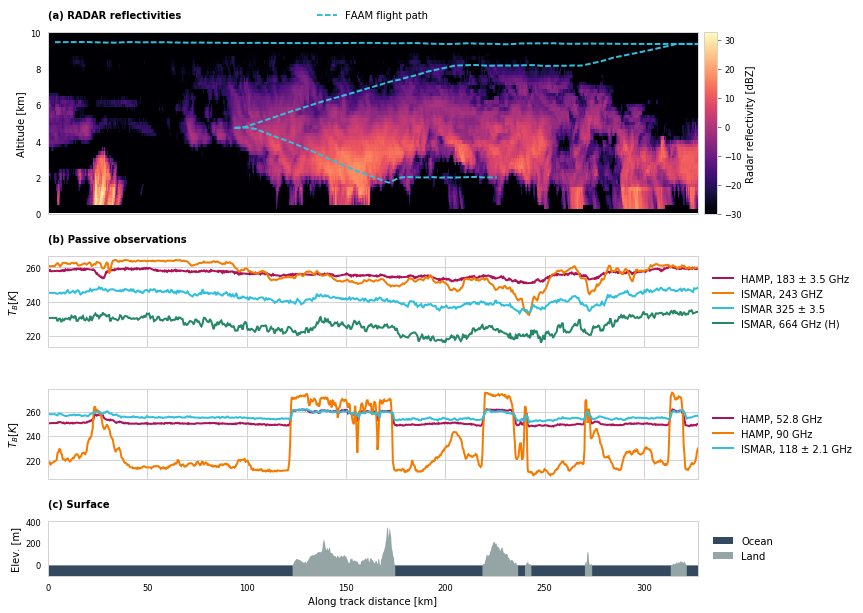

In [20]:
from joint_flight.plots  import grid_to_edges
from joint_flight.data   import hamp, ismar, dem, in_situ
from joint_flight.plots  import grid_to_edges
from matplotlib.gridspec import GridSpec

fig  = plt.figure(figsize = (12, 10))
gs = GridSpec(4, 2, width_ratios = [1, 0.02], hspace = 0.5, wspace = 0.02, height_ratios = [1.0, 0.5, 0.5, 0.3])

x = hamp.d
y = np.linspace(0.2, 10, 50)
xx, yy = np.meshgrid(x, y)
xx = grid_to_edges(xx)
yy = grid_to_edges(yy)

#
# HAMP RADAR
#

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(xx, yy, y_hamp_radar.T, cmap = "magma")
fig.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")

ax.set_title("(a) RADAR reflectivities", loc = "left", fontweight = "bold")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([hamp.d[0], hamp.d[-1]])
ax.xaxis.set_ticks([])
ax.plot(ismar.d_e.ravel(), ismar.zsl_e / 1e3, c = "C2", ls = "--", label = "FAAM flight path", lw = 2)
ax.legend(loc = "upper center", bbox_to_anchor = [0.5, 1.17])

#
# Higher frequencies
#

handles = []
labels  = []
ax = plt.subplot(gs[1, 0])
ax.set_title("(b) Passive observations", loc = "left", fontweight = "bold")
ax.xaxis.set_ticklabels([])
for tb, n, c in zip(upper_tbs, upper_names, upper_cs):
    handles += ax.plot(hamp.d, tb, c = c, lw = 2)
    labels += [n]

ax.set_xlim([hamp.d[0], hamp.d[-1]])
ax.set_ylabel("$T_B [K]$")
    
ax = plt.subplot(gs[1, 1])
ax.legend(handles = handles, labels = labels, loc = "center left", ncol = 1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for s in ax2.spines:
    ax.spines[s].set_visible(False)
    
gs.update(hspace = 0.4)
#
# Lower frequencies
#

handles = []
labels  = []
ax = plt.subplot(gs[2, 0])
ax.xaxis.set_ticklabels([])
for tb, n, c in zip(lower_tbs, lower_names, lower_cs):
    handles += ax.plot(hamp.d, tb, c = c, lw = 2)
    labels += [n]
        
ax.set_xlim([hamp.d[0], hamp.d[-1]])
ax.set_ylabel("$T_B [K]$")
    
ax = plt.subplot(gs[2, 1])
ax.legend(handles = handles, labels = labels, loc = "center left", ncol = 1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for s in ax2.spines:
    ax.spines[s].set_visible(False)



ax1 = plt.subplot(gs[-1, 0])
ax2 = plt.subplot(gs[-1, 1])
make_surface_plot(ax1, ax2)
ax1.set_title("(c) Surface", loc = "left", fontweight = "bold")


plt.tight_layout()
fig.savefig("../plots/observations_combined.pdf", bbox_inches = "tight", dpi = 500)

## PSD

In [16]:
from parts.scattering.psd import D14MN, D14N
d14_ice    = D14N(mass_weighted_diameter = np.array([1.0]),
                  intercept_parameter = np.array([1.0]),
                  alpha = 2.654, beta = 0.750, rho = 917.0)
d14_liquid = D14N(mass_weighted_diameter = np.array([1.0]),
                  intercept_parameter = np.array([1]),
                  alpha = 2.0, beta = 1.0, rho = 917.0)

x = np.linspace(0, 4, 101)
y_ice    = d14_ice.evaluate(x).data
y_liquid = d14_liquid.evaluate(x).data

/home/simon/build/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ARTS API from: /home/simon/build/arts/src/libarts_api.so


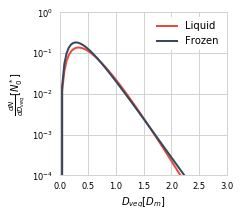

In [17]:
plt.figure(figsize = (3, 3))
plt.plot(x, y_liquid.ravel(), c = palette[-1], lw = 2, label = "Liquid")
plt.plot(x, y_ice.ravel(), c = palette[0], lw = 2, label = "Frozen")
plt.yscale("log")
plt.ylim([1e-4, 1])
plt.xlim([0, 3])
plt.ylabel(r"$\frac{dN}{dD_{veq}} [N_0^*]$")
plt.xlabel("$D_{veq} [D_m]$")
plt.legend()
plt.savefig("../plots/psds.pdf")

In [18]:
y_ice = d14_ice.evaluate

In [19]:
y_ice = d14_ice.evaluate

In [20]:
y_ice = d14_ice.evaluate

## In-situ data

In [21]:
from joint_flight.data import in_situ

In [22]:
in_situ.d_max.shape, in_situ.dndd.shape

((64,), (64, 2098))

In [23]:
from parts.scattering.psd.data.psd_data import PSDData, D_max
psd_8clmn = PSDData(in_situ.d_max, in_situ.dndd.T, D_max(65.4480, 3.0))
psd_aggr  = PSDData(in_situ.d_max, in_situ.dndd.T, D_max(0.1376, 2.4438))

In [24]:
from parts.scattering.psd import D14MN
d14_8clmn = D14MN.from_psd_data(psd_8clmn, 2.654, 0.750, 917.0)
d14_aggr  = D14MN.from_psd_data(psd_aggr, 2.654, 0.750, 917)

/home/simon/src/parts/parts/scattering/psd/d14.py:402: RuntimeWarning: invalid value encountered in true_divide
  dm = m4 / m3
/home/simon/src/parts/parts/scattering/psd/d14.py:404: RuntimeWarning: invalid value encountered in true_divide
  n0 = 4.0 ** 4 / (np.pi * self.rho) * md / dm ** 4


In [25]:
d14_8clmn.moments

[array([4.7785837e+11, 2.6318180e+11, 2.2799394e+11, ..., 6.4417284e+10,
        5.4181597e+10, 1.4327813e+11], dtype=float32),
 array([35.194035 , 20.59289  , 20.45644  , ...,  1.1533033,  0.5687842,
         0.8910537], dtype=float32)]

 ...]

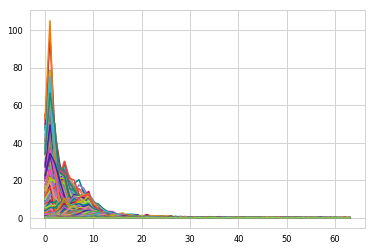

In [26]:
plt.plot(in_situ.dndd[:, :])

In [27]:
d14_8clmn.moment_names

['mass_density', 'intercept_parameter']

(100.0, 100000000000000.0)

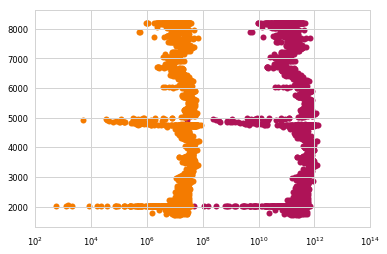

In [28]:
plt.scatter(d14_8clmn.get_mass_density(), in_situ.z_cip)
plt.scatter(d14_aggr.get_mass_density(), in_situ.z_cip)
plt.xscale("log")
plt.xlim([1e2, 1e14])

(100.0, 100000000000000.0)

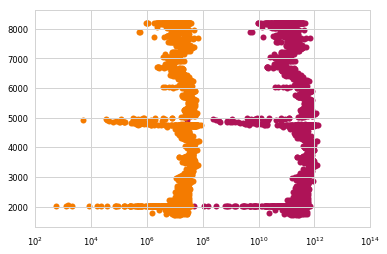

In [29]:
plt.scatter(d14_8clmn.moments[0], in_situ.z_cip)
plt.scatter(d14_aggr.moments[0], in_situ.z_cip)
plt.xscale("log")
plt.xlim([1e2, 1e14])

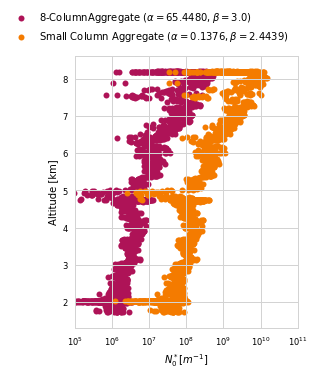

In [30]:

f, axs = plt.subplots(1, 1, figsize = (4, 5))
bins = np.linspace(2, 8, 41)

ax = axs
ax.scatter(d14_8clmn.moments[1] * 1e6, in_situ.z_cip / 1e3, label = r"8-ColumnAggregate ($\alpha = 65.4480, \beta = 3.0$)")
ax.scatter(d14_aggr.moments[1] * 1e6, in_situ.z_cip / 1e3, label = r"Small Column Aggregate ($\alpha = 0.1376, \beta = 2.4439$)")
ax.set_xscale("log")
ax.set_xlim([1e5, 1e11])

ax.set_ylabel("Altitude [km]")
ax.set_xlabel("$N_0^* [m^{-1}]$")
ax.legend(bbox_to_anchor = [1.0, 1.2])

#ax = axs[1]
#ax.scatter(d14_8clmn.moments[1] * 1e6, in_situ.z_cip / 1e3, label = r"8-ColumnAggregate ($\alpha = 65.4480, \beta = 3.0$)")
#ax.scatter(d14_aggr.moments[1] * 1e6, in_situ.z_cip / 1e3, label = r"Small Column Aggregate ($\alpha = 0.1376, \beta = 2.4439$)")
#ax.set_xscale("log")
#ax.set_xlim([1e5, 1e11])
#
#ax.set_ylabel("Altitude [km]")
#ax.set_xlabel("$N_0^* [m^{-1}]$")
f.savefig("../plots/N0.pdf", bbox_inches = "tight")

In [31]:
mm

NameError: name 'mm' is not defined

In [ ]:
d14_8clmn.moment_names

In [ ]:
from matplotlib.gridspec import GridSpec

f  = plt.figure(figsize = (12, 8))
gs = GridSpec(3, 2, width_ratios = [1, 0.01], wspace = 0.1)

cs = ["navy", "darkorchid", "dodgerblue", "darkcyan", 
      "orange", "orangered", "firebrick"]

csd = 57
csi = np.where(hamp_d > csd)[0][0]

ax = plt.subplot(gs[0, 0])
img = ax.pcolormesh(hamp_d, hamp_z[:] / 1e3, hamp_dbz.T)
f.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "Radar reflectivity [dBZ]")
ax.axvline(x = hamp_d[csi], c = "k", ls = "--")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 10])
ax.set_xlim([0, 320])
ax.plot(hamp_d.ravel(), hamp_surf.ravel(), c = "k", lw = 3)

ax = plt.subplot(gs[1, 0])

ci = 0
channel_names = []
for n in channel_names_hamp:
    channel_names += n
    
handles = []
labels  = []

for j, i in enumerate(np.where(np.diff(hamp_channels))[0]):
    
    ax = plt.subplot(gs[1, 0])
    mn = hamp_bt[csi, i]
    handles += ax.plot(hamp_d, hamp_bt[:, i] - mn, c = cs[ci], label = channel_names[i])
    labels  += [channel_names[i]]
    ci += 1
    ax.set_xlim([0, 320])
    ax.set_ylim([-10, 130])
    ax.set_ylabel("$\Delta T_B [K]$")
    
ax.axvline(x = hamp_d[csi], c = "k", ls = "--")
ax = plt.subplot(gs[1, 1])
ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()
            
channel_names = []
for n in channel_names_ismar:
    channel_names += n

ax = plt.subplot(gs[2, 0])
csi = np.where(ismar_d > csd)[0][0]
    
handles = []
labels  = []

for i, j in enumerate([6, 9, 18]):
    first = True
    
    y_min = 300.0
    y_max = 280.0
    
    mn = ismar_tbs[csi, j]
    handles += ax.plot(ismar_d, ismar_tbs[:, j] - mn, c = cs[ci], label = channel_names[j])
    labels  += [channel_names[j]]
    ci += 1
            
    ax.set_xlim([0, 320])
    ax.set_ylim([-30, 10])
    ax.set_ylabel("$\Delta T_B [K]$")
    
ax.axvline(x = ismar_d[csi], c = "k", ls = "--")
ax.set_xlabel("Along track distance [km]")

ax = plt.subplot(gs[2, 1])
ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()

plt.tight_layout()
f.savefig("../plots/ici_frequencies.png", bbox_inches = "tight")

## FAAM Dropsondes

/home/simon/src/matplotlib/lib/matplotlib/figure.py:2052: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


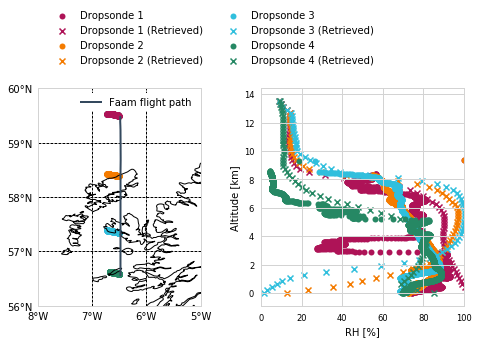

In [32]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors     import Normalize
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 2, width_ratios = [1.0, 1.0], hspace = 0.25)
fig = plt.figure(figsize = (8, 4))
ax  = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())

c1 = "#1b9e77"
c2 = "#d95f02"
c3 = "navy"

ax.plot(ismar.lon + 0.025, ismar.lat, lw = 2, label = "Faam flight path", c = palette[0])
for la, lo in zip(in_situ.ds_lat, in_situ.ds_lon):
    ax.scatter(lo, la)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlocator   = mticker.FixedLocator(np.linspace(-8, -5, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.ylocator   = mticker.FixedLocator(np.linspace(56, 60, 5))
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top   = False

ax.coastlines(resolution = "10m", linewidth = 1)

norm = Normalize(vmin = 0, vmax = 500)
ax.set_xlim([-8.0001, -4.9999])
ax.set_ylim([55.9999, 60.0001])
ax.legend()

for s in ax.spines:
    ax.spines[s].set_visible(True)

ax = plt.subplot(gs[1])
for i in range(4):
    ax.scatter(in_situ.ds_rh[i], in_situ.ds_z[i] / 1e3, c = "C" + str(i), label = "Dropsonde " + str(i + 1))
    z  = np.linspace(0, 13.5, 66)
    rh = np.load("../data/h2o_" + str(i + 1) + ".npy")
    ax.scatter(rh * 100, z, c = "C" + str(i), marker = "x", label = "Dropsonde " + str(i + 1) + " (Retrieved)")
    
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("RH [%]")
ax.set_xlim([0, 100])
ax.legend(ncol = 2, bbox_to_anchor = [0.6, 1.4])
plt.tight_layout()
fig.savefig("../plots/rh_retrieval.png")

In [34]:
from typhon.physics import e_eq_ice_mk, e_eq_water_mk

In [ ]:
rh.shape

In [ ]:
rh

## Era 5 Data

In [ ]:
from netCDF4 import Dataset

era_5      = Dataset("../data/era_5_surface.nc", "r")
era_5_lon  = era_5.variables["longitude"][:]
era_5_lat  = era_5.variables["latitude"][:]
era_5_u_10 = era_5.variables["u10"][:]
era_5_v_10 = era_5.variables["v10"][:]
era_5_sst  = era_5.variables["sst"][:]
era_5_skt  = era_5.variables["skt"][:]

In [ ]:
f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_u_10[0, ::-1, :].T)
hamp_u_10 = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_v_10[0, ::-1, :].T)
hamp_v_10 = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_sst[0, ::-1, :].T)
hamp_sst = f((hamp_lon + 360.0, hamp_lat))

f = RegularGridInterpolator((era_5_lon, era_5_lat[::-1]), era_5_skt[0, ::-1, :].T)
hamp_skt = f((hamp_lon + 360.0, hamp_lat))

In [ ]:
from netCDF4 import Dataset

era_5      = Dataset("../data/era_5.nc", "r")
era_5_lon  = era_5.variables["longitude"][:]
era_5_lat  = era_5.variables["latitude"][:]
era_5_z    = era_5.variables["z"][:]
era_5_p   = np.array(['1','2','3', '5','7','10', '20','30','50',
                      '70','100','125', '150','175','200', '225',
                      '250','300', '350','400','450', '500','550',
                      '600', '650','700','750', '775','800','825',
                      '850','875','900', '925','950','975', '1000'], dtype = np.float64)

f = RegularGridInterpolator((era_5_p, era_5_lat[::-1], era_5_lon), era_5_z[0, :, ::-1, :])

In [ ]:
p = np.linspace(1000, sonde_p.min(), 501)
pp, lat = np.meshgrid(p, hamp_lat)
pp, lon = np.meshgrid(p, hamp_lon)
z_interp = f((pp, lat, lon + 360))

## Retrieval data

We need to ensure that the pressure grid is decreasing.

In [ ]:
from netCDF4 import Dataset
ds = Dataset("../data/input.nc", "w")

In [ ]:
z_ss  = 5
z_ind = np.where(hamp_z > 12e3)[0][0]

In [ ]:
profile_index = ds.createDimension("profile_index", hamp_d.size)
altitude      = ds.createDimension("altitude", hamp_z[:z_ind:z_ss].size)

ds.createVariable("sea_surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("surface_temperature", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_u", "f8", dimensions = ("profile_index",))
ds.createVariable("wind_v", "f8", dimensions = ("profile_index",))
ds.createVariable("pressure", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("humidity", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("H2O", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("temperature", "f8", dimensions = ("profile_index", "altitude"))

In [ ]:
ds.variables["sea_surface_temperature"][:] = hamp_sst
ds.variables["surface_temperature"][:] = hamp_skt
ds.variables["wind_u"][:] = hamp_u_10
ds.variables["wind_v"][:] = hamp_v_10

In [ ]:
ds.createVariable("altitude", "f8", ("profile_index", "altitude"))
ds.variables["altitude"][:] = np.broadcast_to(hamp_z.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

In [ ]:
from typhon.physics.atmosphere import relative_humidity2vmr

pressure = np.zeros((hamp_d.size, hamp_z.size))
humidity = np.zeros((hamp_d.size, hamp_z.size))
temperature = np.zeros((hamp_d.size, hamp_z.size))
altitude = np.broadcast_to(hamp_z.reshape(1, -1), pressure.shape)

#for i in range(hamp_z.size):
pressure[:, :] = 100 * sonde_p[3, :] #np.interp(hamp_d, sonde_d[:, i], sonde_p[:, i])
humidity[:, :] = sonde_rh[3, :] / 100 #np.interp(hamp_d, sonde_d[:, i], sonde_rh[:, i])
temperature[:, :] = sonde_t[3, :] #np.interp(hamp_d, sonde_d[:, i], sonde_t[:, i])

dp = np.diff(pressure, axis = 1)
for i in range(dp.shape[1]):
    if np.any(dp[:, i] == 0):
        pressure[:, i] -= 0.5 * dp[:, i - 1]
        pressure[:, i + 1] += 0.5 * dp[:, i - 1]
    
ds.variables["pressure"][:, :] = pressure[:, :z_ind:z_ss]
ds.variables["humidity"][:, :] = humidity[:, :z_ind:z_ss]
ds.variables["H2O"][:, :] = relative_humidity2vmr(humidity, pressure, temperature)[:, :z_ind:z_ss]
ds.variables["temperature"][:, :] = temperature[:, :z_ind:z_ss]

In [ ]:
ds.createVariable("O2", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("O3", "f8", dimensions = ("profile_index", "altitude"))
ds.createVariable("N2", "f8", dimensions = ("profile_index", "altitude"))

In [ ]:
z_b = np.array([119.26605505,  2118.57516973,   4027.60345297,   5862.87711004,
             7627.64498975,  9297.02869728,  10892.59889357,  12434.63769365,
             13904.25695207, 15290.83137241,  16635.83815029,  17963.99841403,
             19346.95698534, 20750.73842791,  22184.62422791,  23675.44467966,
             25180.02964216, 26780.47609985,  28320.01292605,  29820.7853969 ,
             31494.56521739])
o2  = np.array([ 0.20914768,  0.20917247,  0.20911265,  0.20919441,  0.20921843,
              0.20915963,  0.20914215,  0.20918673,  0.20921144,  0.20916823,
              0.20915074,  0.20918311,  0.20910791,  0.20914558,  0.20908499,
              0.20913025,  0.20910134,  0.20907593,  0.20910521,  0.2091797 ,
              0.20917443])
o2 = np.interp(hamp_z, z_b, o2)
ds.variables["O2"][:, :] = np.broadcast_to(o2.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

o3  = np.array([2.90479819e-08,   3.36389220e-08,   3.56864241e-08,
                3.96190027e-08,   4.38274934e-08,   5.18099738e-08,
                6.50830255e-08,   8.46137019e-08,   1.03927382e-07,
                1.31159885e-07,   2.11682715e-07,   4.91257992e-07,
                1.10672315e-06,   1.70139678e-06,   2.58579126e-06,
                4.01127013e-06,   5.57665027e-06,   7.11467740e-06,
                8.29916685e-06,   9.20149730e-06,   9.63690492e-06])
o3 = np.interp(hamp_z, z_b, o3)
ds.variables["O3"][:, :] = np.broadcast_to(o3.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]

n2 = np.array([0.78143085,  0.78164177,  0.78123672,  0.78189026,  0.78169185,
               0.78155673,  0.78151964,  0.78156695,  0.78156223,  0.78157601,
               0.78164542,  0.78170006,  0.78154427,  0.78127151,  0.78165497,
               0.78161547,  0.7815775 ,  0.78152597,  0.78153412,  0.78159145,
               0.78158467])
n2 = np.interp(hamp_z, z_b, n2)
ds.variables["N2"][:, :] = np.broadcast_to(n2.reshape(1, -1), hamp_dbz.shape)[:, :z_ind:z_ss]


### Hamp radar

In [ ]:
y = np.maximum(hamp_dbz.data, -30)
dz = hamp_z - np.maximum(hamp_surf.reshape(-1, 1) * 1000, 0.0)
y[dz < 250] = -30
#plt.pcolor(y.T)

In [ ]:
ds.createVariable("y_hamp_radar", "f8", dimensions = ("profile_index", "altitude"))
ds.variables["y_hamp_radar"][:, :] = y[:, :z_ind:z_ss]

### Hamp radiometer

In [ ]:
ds.createDimension("hamp_channels", size = 26)
ds.createVariable("y_hamp_passive", "f8", dimensions = ("profile_index", "hamp_channels"))

In [ ]:
hamp_bt[22, :]

In [ ]:
ds.variables["y_hamp_passive"][:, :] = hamp_bt

## Rasta radar

In [ ]:
y_rasta = -16 * np.ones(rasta_dbz.shape)
inds    = np.logical_not(rasta_dbz.mask)
y_rasta[inds] = np.maximum(rasta_dbz[inds], -16)
for i in range(rasta_dbz.shape[0]):
    inds = 0.2 > rasta_z[i, :] - np.maximum(rasta_surf[i], 0.0)
    y_rasta[i, inds] = -16
y_rasta[:, 200:] = -16

In [ ]:
def center_to_edges(z):
    range_bins = np.zeros(z.size + 1)
    range_bins[1:-1] = 0.5 * (z[1:] + z[:-1])
    range_bins[0]  = 2 * range_bins[1] - range_bins[2]
    range_bins[-1] = 2 * z[-1] - z[-2]
    return range_bins

In [ ]:
rasta_range_bins = np.zeros((rasta_z.shape[0], rasta_z.shape[1] + 1))
for i in range(rasta_z.shape[0]):
    z = center_to_edges(rasta_z[i, :])
    rasta_range_bins[i, :] = z
    
y_rasta_i = np.zeros((hamp_d.size, rasta_z.shape[1]))
rasta_range_bins_i = np.zeros((hamp_d.size, rasta_z.shape[1] + 1))
for i in range(rasta_z.shape[1]):
    y_rasta_i[:, i]    = np.interp(hamp_d, rasta_d, y_rasta[:, i])
    rasta_range_bins_i[:, i] = np.interp(hamp_d, rasta_d, rasta_range_bins[:, i])

In [ ]:
ds.createDimension("rasta_range_bins", y_rasta_i[:, ::z_ss].shape[1] + 1)
ds.createVariable("rasta_range_bins", "f8", ("profile_index", "rasta_range_bins",))
ds.variables["rasta_range_bins"][:, :] = rasta_range_bins_i[:, ::z_ss]

In [ ]:
ds.createDimension("rasta_gates", y_rasta_i[:, ::z_ss].shape[1])
ds.createVariable("y_rasta", "f8", dimensions = ("profile_index", "rasta_gates"))
ds.variables["y_rasta"][:, :] = y_rasta_i[:, ::z_ss]

### ISMAR radiometer

In [ ]:
ismar_tbs_i = np.zeros((hamp_d.size, 21))
ismar_nedt_i = np.zeros((hamp_d.size, 21))
for i in range(21):
    ismar_tbs_i[:, i] = np.interp(hamp_d, ismar_d, ismar_tbs[:, i])
    ismar_nedt_i[:, i] = np.interp(hamp_d, ismar_d, ismar_nedt[:, i])

For the ISMAR radiomenter not all channels contain useful information. For the retrieval
only the following channels will be used:

| Frequency [GHz] | Number of channels| Original channel indices  |
|-----------------|-------------------|---------------------------|
| 118             |         5         |            0, 1, 2, 3, 4  |
| 243             |         1         |            mean of 5, 6   |
| 325             |         3         |                 7, 8, 9   |
| 664             |         1         |                 10        |


In [ ]:
y_ismar = np.zeros((hamp_d.size, 10))
y_ismar_nedt = np.zeros((hamp_d.size, 10))

# 118 GHz
y_ismar[:, :5] = ismar_tbs_i[:, :5]
y_ismar_nedt[:, :5] = ismar_nedt_i[:, :5]

# 243 GHz
y_ismar[:, 5] = np.mean(ismar_tbs_i[:, 5 : 7], axis = 1)
y_ismar_nedt[:, 5] = np.sqrt(np.sum(ismar_nedt_i[:, 5 : 7] ** 2, axis = 1) / 2.0)

# 325 GHz
y_ismar[:, 6 : 9] = ismar_tbs_i[:, 7 : 10]
y_ismar_nedt[:, 6 : 9] = ismar_nedt_i[:, 7 : 10]

# 664 GHz
y_ismar[:, 9] = ismar_tbs_i[:, 10]
y_ismar_nedt[:, 9] = ismar_nedt_i[:, 10]

In [ ]:
ismar_nedt_i.shape

In [ ]:
plt.plot(ismar_nedt_i[:, -4])

In [ ]:
ds.createDimension("ismar_channels", size = 10)
ds.createVariable("y_ismar", "f8", dimensions = ("profile_index", "ismar_channels"))
ds.createVariable("y_ismar_nedt", "f8", dimensions = ("profile_index", "ismar_channels"))
ds["y_ismar"][:] = y_ismar
ds["y_ismar_nedt"][:] = y_ismar_nedt

In [ ]:
ds.close()